In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Install Required Libraries
!pip install xgboost shap prophet pmdarima tensorflow --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.0 MB/s eta 0:00:00


In [3]:
#Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

# For time series
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX

# For LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tqdm import tqdm

In [4]:
# Load and Merge Data

train = pd.read_csv("/content/drive/MyDrive/Capstone Project/train.csv", parse_dates=["Date"])
store = pd.read_csv("/content/drive/MyDrive/Capstone Project/store.csv")

# Merge datasets
df = pd.merge(train, store, on="Store")
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
# Clean & Preprocess Data
# Fill missing values

df['CompetitionDistance'].fillna(df['CompetitionDistance'].median(), inplace=True)
df['StateHoliday'] = df['StateHoliday'].astype(str)

In [6]:
#Feature Engineering

# Create date-related features

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['WeekOfYear'] = df['Date'].dt.isocalendar().week
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6])
df['PromoRunning'] = (df['Promo'] == 1) & (df['Open'] == 1)

df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,IsWeekend,PromoRunning
0,1,4,2015-07-31,5263,555,1,1,0,1,c,...,0,NaN,NaN,NaN,2015,7,31,31,False,True
1,2,4,2015-07-31,6064,625,1,1,0,1,a,...,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,False,True
2,3,4,2015-07-31,8314,821,1,1,0,1,a,...,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,False,True
3,4,4,2015-07-31,13995,1498,1,1,0,1,c,...,0,NaN,NaN,NaN,2015,7,31,31,False,True
4,5,4,2015-07-31,4822,559,1,1,0,1,a,...,0,NaN,NaN,NaN,2015,7,31,31,False,True


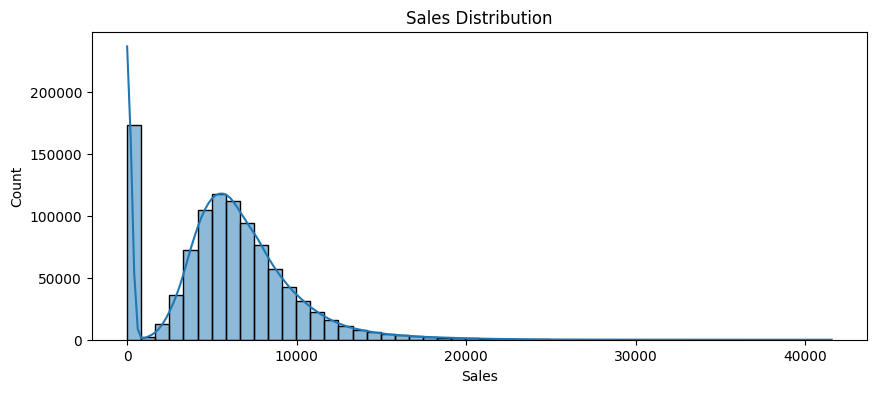

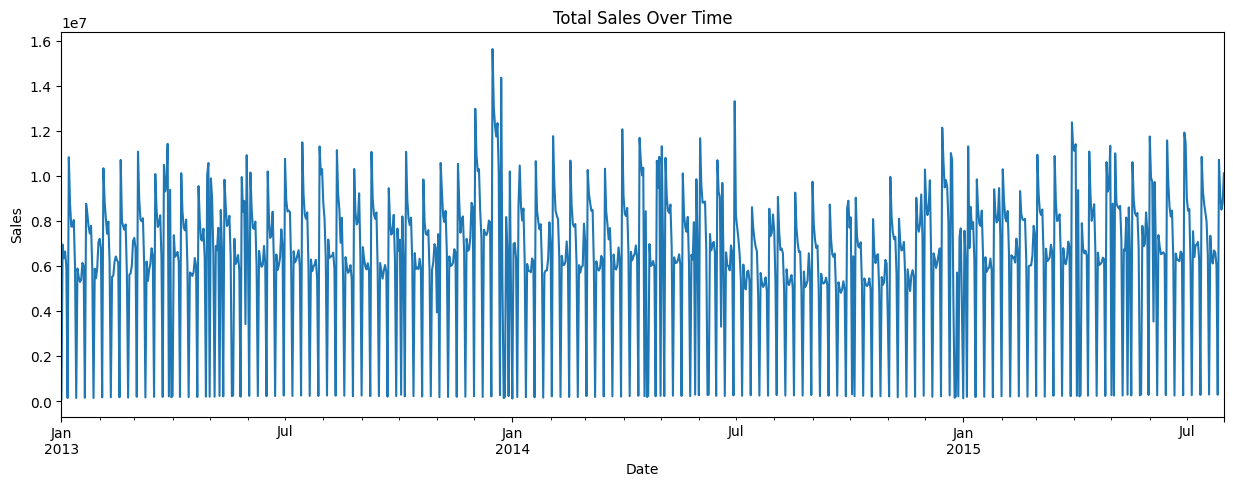

In [7]:
# EDA – Visualize Sales Trends

plt.figure(figsize=(10,4))
sns.histplot(df['Sales'], bins=50, kde=True)
plt.title('Sales Distribution')
plt.show()

# Sales over time
df.groupby('Date')['Sales'].sum().plot(figsize=(15, 5), title='Total Sales Over Time')
plt.ylabel('Sales')
plt.show()


In [8]:
# Baseline Model – Linear Regression

model_df = df[(df['Open'] == 1) & (df['Sales'] > 0)].copy()

features = ['Store', 'Promo', 'DayOfWeek', 'Month', 'Year']
X = model_df[features]
y = model_df['Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Linear Regression MAE:", mean_absolute_error(y_test, y_pred))

Linear Regression RMSE: 2818.890915809172
Linear Regression MAE: 2005.879302679858


Random Forest RMSE: 1242.7580912859767
Random Forest MAE: 854.9868925638202


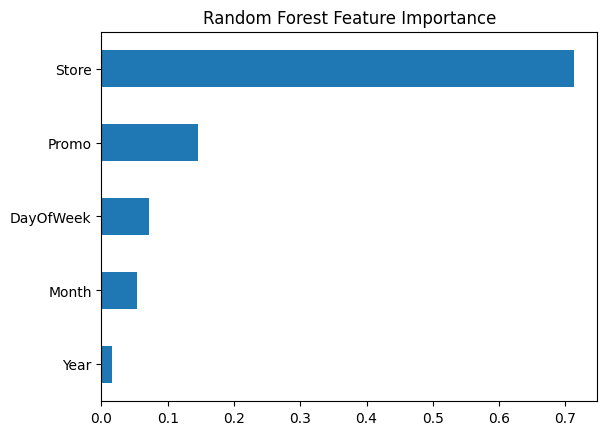

In [9]:
# Random Forest Model with Feature Importance

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("Random Forest MAE:", mean_absolute_error(y_test, y_pred_rf))

importances = pd.Series(rf.feature_importances_, index=features)
importances.sort_values().plot(kind='barh')
plt.title("Random Forest Feature Importance")
plt.show()

XGBoost RMSE: 2524.008716308246
XGBoost MAE: 1862.8778076171875


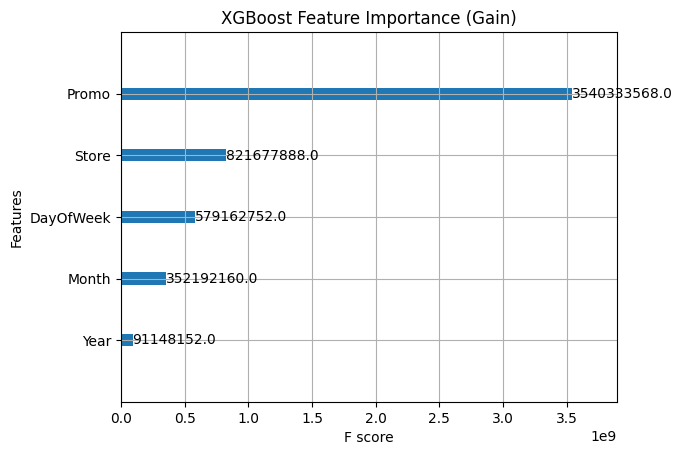

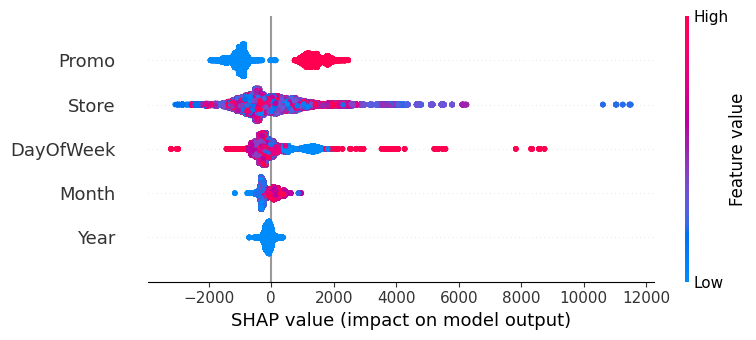

In [10]:
# XGBoost Model

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("XGBoost MAE:", mean_absolute_error(y_test, y_pred_xgb))

# Feature Importance
xgb.plot_importance(xgb_model, importance_type='gain')
plt.title("XGBoost Feature Importance (Gain)")
plt.show()

explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

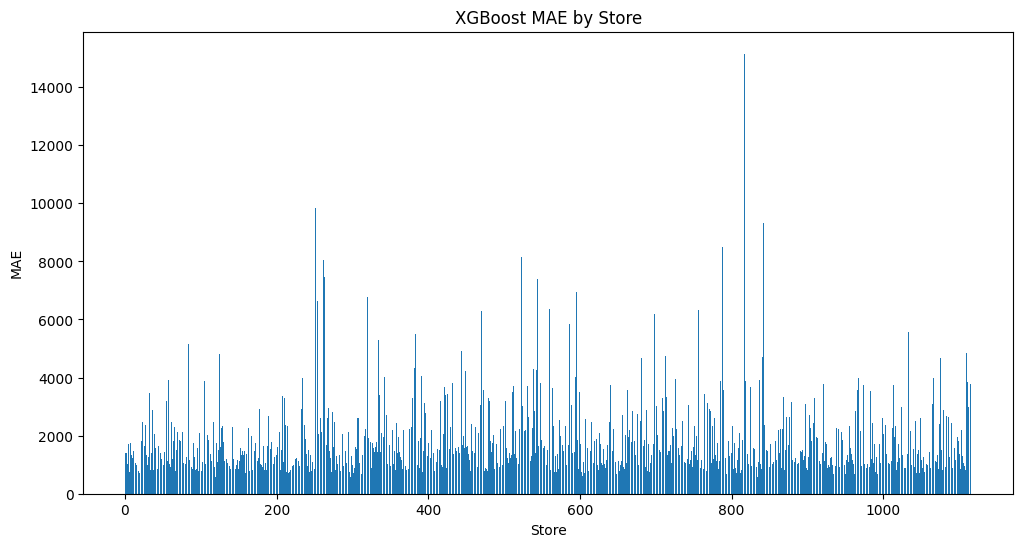

In [11]:
# Store-Level Performance Analysis (XGBoost)

X_test_with_store = X_test.copy()
X_test_with_store['Store'] = model_df.loc[X_test.index, 'Store']
X_test_with_store['Actual'] = y_test
X_test_with_store['Predicted_XGB'] = y_pred_xgb

store_mae = X_test_with_store.groupby('Store').apply(lambda x: mean_absolute_error(x['Actual'], x['Predicted_XGB'])).reset_index()
store_mae.columns = ['Store', 'MAE_XGB']

plt.figure(figsize=(12,6))
plt.bar(store_mae['Store'], store_mae['MAE_XGB'])
plt.xlabel("Store")
plt.ylabel("MAE")
plt.title("XGBoost MAE by Store")
plt.show()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaebej2rt/8_84xxgn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaebej2rt/tkgm2zqf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55561', 'data', 'file=/tmp/tmpaebej2rt/8_84xxgn.json', 'init=/tmp/tmpaebej2rt/tkgm2zqf.json', 'output', 'file=/tmp/tmpaebej2rt/prophet_model19xwo51d/prophet_model-20250713162502.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:25:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:25:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


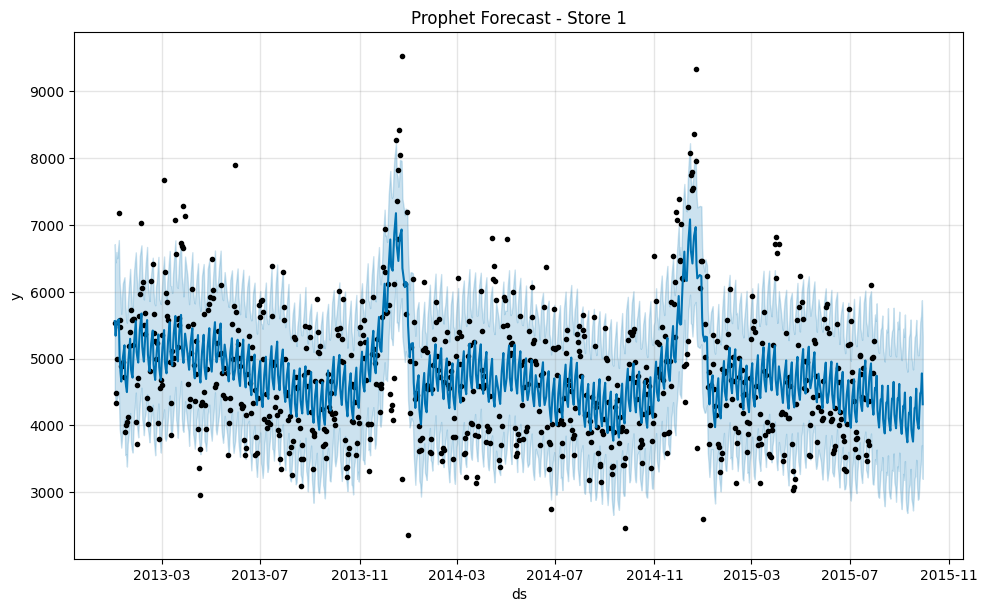

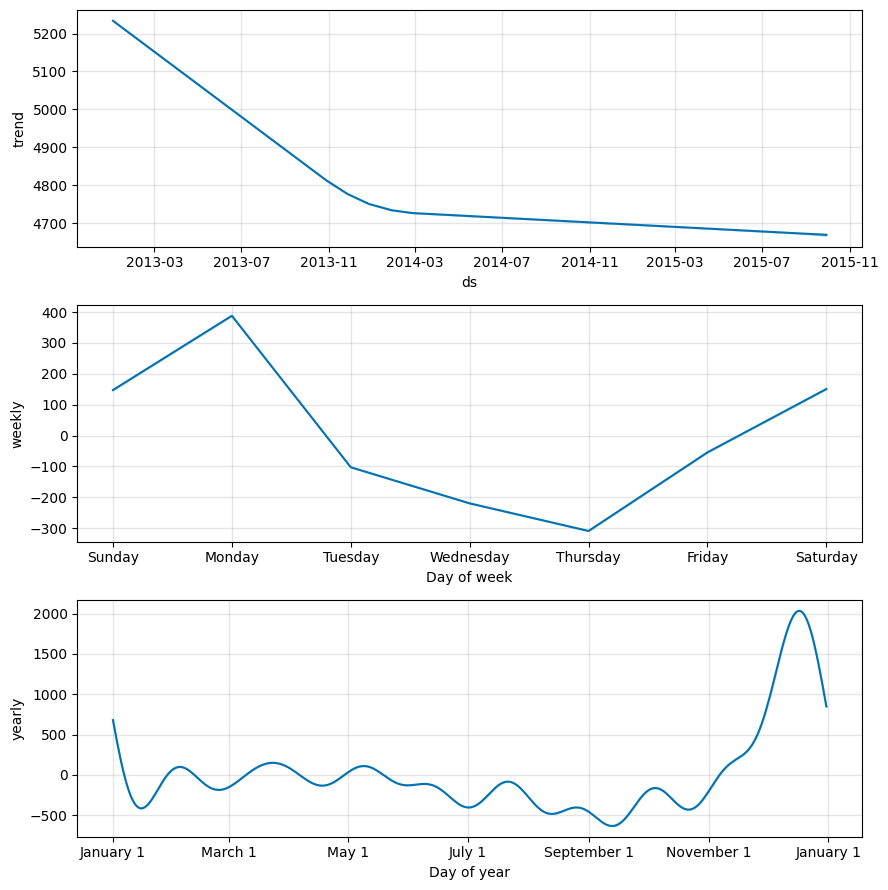

In [12]:
# Prophet: Time Series Forecasting for Store 1

store1_df = df[(df['Store'] == 1) & (df['Open'] == 1) & (df['Sales'] > 0)]
store1_ts = store1_df.groupby('Date')['Sales'].sum().reset_index()
prophet_df = store1_ts.rename(columns={'Date':'ds','Sales':'y'})

model_p = Prophet()
model_p.fit(prophet_df)

future = model_p.make_future_dataframe(periods=60)
forecast = model_p.predict(future)

model_p.plot(forecast)
plt.title("Prophet Forecast - Store 1")
plt.show()

model_p.plot_components(forecast)
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                             Sales   No. Observations:                  781
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -6143.460
Date:                           Sun, 13 Jul 2025   AIC                          12296.921
Time:                                   16:25:33   BIC                          12320.113
Sample:                                        0   HQIC                         12305.850
                                           - 781                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6434      0.026     24.791      0.000       0.592       0.694
ma.L1         -0.9666      0.008   -121.186

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


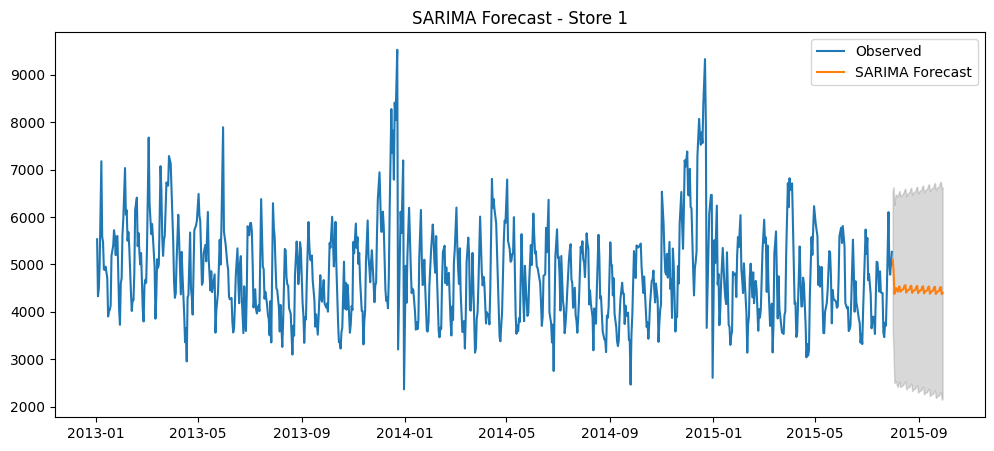

In [14]:
# SARIMA: Time Series Forecasting for Store 1

store_ts_arima = store1_ts.set_index('Date')['Sales']

model_sarima = SARIMAX(store_ts_arima,
                       order=(1,1,1),
                       seasonal_order=(1,1,1,7),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

results = model_sarima.fit()
print(results.summary())

forecast = results.get_forecast(steps=60)
forecast_ci = forecast.conf_int()
forecast_index = pd.date_range(start=store_ts_arima.index[-1] + pd.Timedelta(days=1), periods=60)
forecast_values = forecast.predicted_mean

plt.figure(figsize=(12,5))
plt.plot(store_ts_arima, label="Observed")
plt.plot(forecast_index, forecast_values, label="SARIMA Forecast")
plt.fill_between(forecast_index, forecast_ci.iloc[:,0], forecast_ci.iloc[:,1], color='gray', alpha=0.3)
plt.title("SARIMA Forecast - Store 1")
plt.legend()
plt.show()

100%|██████████| 1115/1115 [00:19<00:00, 58.66it/s]


Epoch 1/5
5069/5069 ━━━━━━━━━━━━━━━━━━━━ 150s 29ms/step - loss: 0.0204
Epoch 2/5
5069/5069 ━━━━━━━━━━━━━━━━━━━━ 152s 30ms/step - loss: 0.0135
Epoch 3/5
5069/5069 ━━━━━━━━━━━━━━━━━━━━ 147s 29ms/step - loss: 0.0117
Epoch 4/5
5069/5069 ━━━━━━━━━━━━━━━━━━━━ 146s 29ms/step - loss: 0.0105
Epoch 5/5
5069/5069 ━━━━━━━━━━━━━━━━━━━━ 202s 29ms/step - loss: 0.0096
5069/5069 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step
LSTM (Full Dataset) RMSE (scaled): 0.0973
LSTM (Full Dataset) MAE (scaled): 0.0692


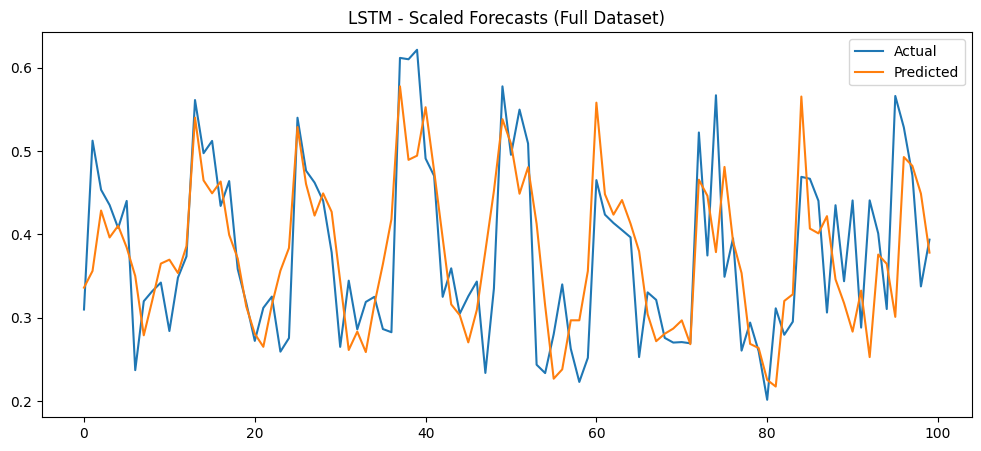

In [22]:
# LSTM Model Development


sequence_length = 30
X_all, y_all = [], []

store_ids = df['Store'].unique()

for store in tqdm(store_ids):
    store_data = df[(df['Store'] == store) & (df['Open'] == 1) & (df['Sales'] > 0)].copy()
    store_data = store_data.sort_values('Date')

    scaler = MinMaxScaler()
    scaled_sales = scaler.fit_transform(store_data[['Sales']])

    for i in range(len(scaled_sales) - sequence_length):
        X_all.append(scaled_sales[i:i+sequence_length])
        y_all.append(scaled_sales[i+sequence_length])

X_all = np.array(X_all)
y_all = np.array(y_all)

split = int(len(X_all) * 0.8)
X_train, X_test = X_all[:split], X_all[split:]
y_train, y_test = y_all[:split], y_all[split:]

model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length,1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=5, batch_size=128)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"LSTM (Full Dataset) RMSE (scaled): {rmse:.4f}")
print(f"LSTM (Full Dataset) MAE (scaled): {mae:.4f}")

# Plot sample predictions
plt.figure(figsize=(12, 5))
plt.plot(y_test[:100], label='Actual')
plt.plot(y_pred[:100], label='Predicted')
plt.title("LSTM - Scaled Forecasts (Full Dataset)")
plt.legend()
plt.show()

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0887 - val_loss: 0.0557
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0180 - val_loss: 0.0409
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0180 - val_loss: 0.0374
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0156 - val_loss: 0.0370
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0158 - val_loss: 0.0367
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0164 - val_loss: 0.0381
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0159 - val_loss: 0.0375
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0135 - val_loss: 0.0350
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0151 - val_loss: 0.0343
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0163 - val_loss: 0.0373
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0163 - val_loss: 0.0344
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0

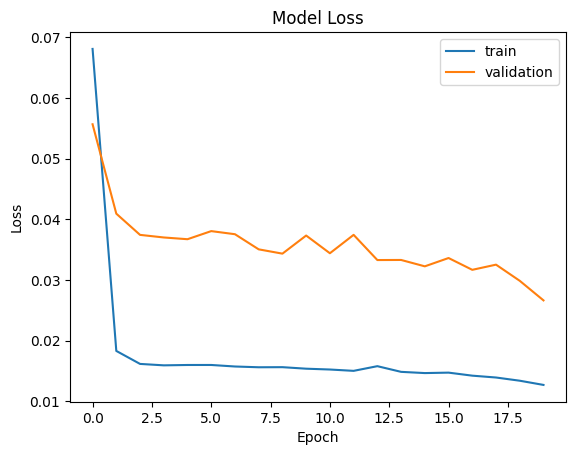

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
LSTM RMSE: 709.7589554635351
LSTM MAE: 592.2353968336092


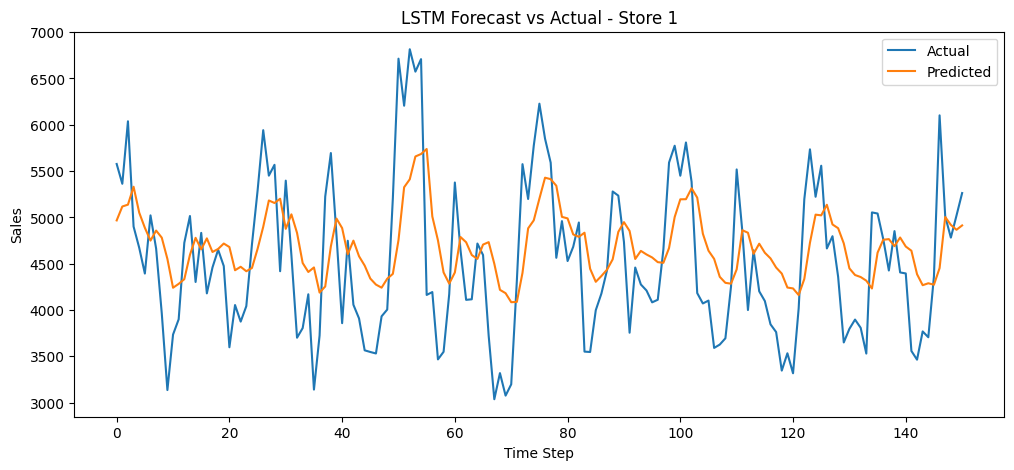

In [23]:
# LSTM Model Development for Store 1

# Define sequence length
SEQ_LENGTH = 30

# 2. Prepare dataset for Store 1
# Filter only open stores with valid sales for Store 1
store_data = df[(df['Store'] == 1) & (df['Open'] == 1) & (df['Sales'] > 0)].copy()
store_data = store_data.sort_values('Date')

# 3. Normalize and generate sequences for Store 1
scaler = MinMaxScaler()
scaled_sales = scaler.fit_transform(store_data[['Sales']])

X, y = [], []

# Create sequences
for i in range(len(scaled_sales) - SEQ_LENGTH):
    X.append(scaled_sales[i:i + SEQ_LENGTH])
    y.append(scaled_sales[i + SEQ_LENGTH])

X = np.array(X)
y = np.array(y)

# 4. Train-test split (for Store 1 data)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


# 5. Build LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(SEQ_LENGTH, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Train model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

# 7. Plot training & validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# 8. Predict on test set
y_pred = model.predict(X_test)

# Inverse transform to original scale
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# 9. Evaluate model
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)

print("LSTM RMSE:", rmse)
print("LSTM MAE:", mae)

# 10. Plot actual vs predicted
plt.figure(figsize=(12,5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('LSTM Forecast vs Actual - Store 1')
plt.xlabel('Time Step')
plt.ylabel('Sales')
plt.legend()
plt.show()

Model Performance Summary
               Model     RMSE      MAE
0  Linear Regression  2818.89  2005.88
1            XGBoost  2524.01  1862.88
2               LSTM   709.76   592.24
3      Random Forest  1242.76   854.99


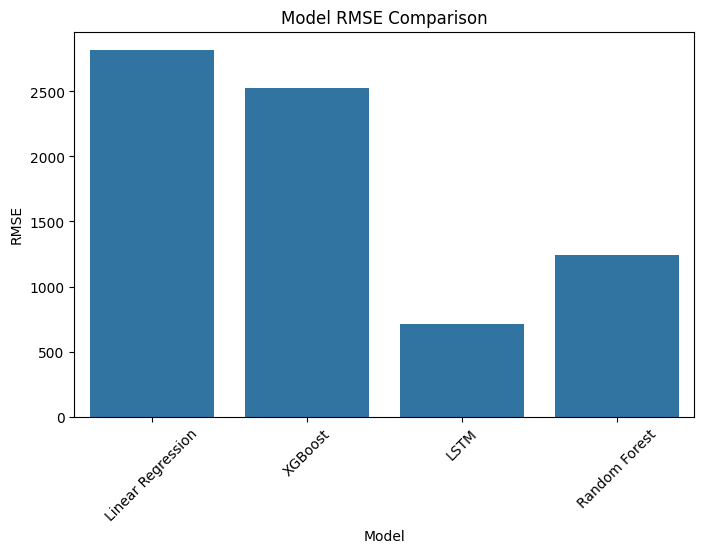

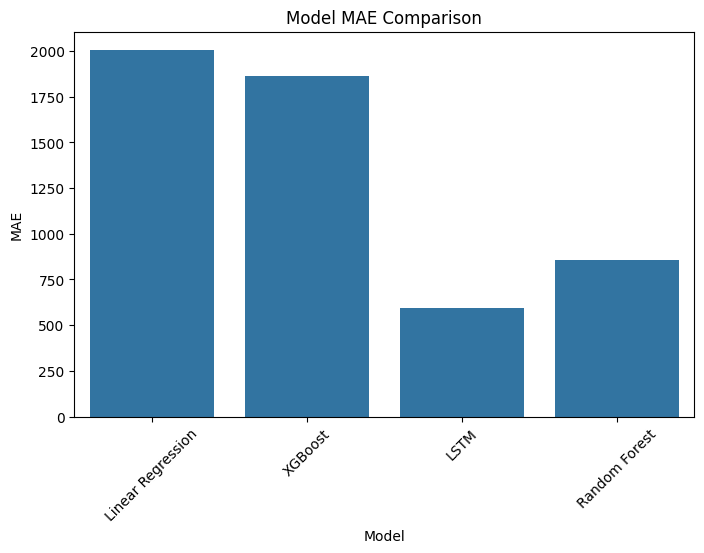

In [25]:
# Store model results with final LSTM metrics

results = {
    'Model': ['Linear Regression', 'XGBoost', 'LSTM', 'Random Forest'],
    'RMSE': [2818.89, 2524.01, 709.76, 1242.76],
    'MAE': [2005.88, 1862.88, 592.24, 854.99]
}


# Create dataframe
results_df = pd.DataFrame(results)
print("Model Performance Summary")
print(results_df)

# Visualize RMSE comparison
plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x='Model', y='RMSE')
plt.title('Model RMSE Comparison')
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.show()

# Visualize MAE comparison
plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x='Model', y='MAE')
plt.title('Model MAE Comparison')
plt.ylabel('MAE')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.show()

# Interpretation prompt

# - LSTM has significantly lower RMSE and MAE compared to Linear Regression and XGBoost.
# - This suggests LSTM captures temporal patterns in sales data better.
# - However, LSTM requires higher computational resources and longer training time.
# - XGBoost remains strong for tabular feature-based regression tasks.
